# Generative Adversarial Networks

<img src="GAN.JPG">

## Download MNIST and load it

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

from keras.datasets import mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()
train_data = train_data / 255.
test_data = test_data / 255.

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0):
    ''' Tile images in a grid.
    If tile_shape is provided only as many images as specified in tile_shape
    will be included in the output.
    '''
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i * grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

    return tile_img


def plot_network_output(data, reconst_data, generated, step):
    num = 8
    
    fig, ax = plt.subplots(nrows=3, ncols=num, figsize=(18, 6))
    for i in xrange(num):
        ax[(0, i)].imshow(np.squeeze(generated[i]), cmap=plt.cm.gray)
        ax[(1, i)].imshow(np.squeeze(data[i]), cmap=plt.cm.gray)
        ax[(2, i)].imshow(np.squeeze(reconst_data[i]), cmap=plt.cm.gray)
        ax[(0, i)].axis('off')
        ax[(1, i)].axis('off')
        ax[(2, i)].axis('off')

    fig.suptitle('Top: generated | Middle: data | Bottom: recunstructed')
#     plt.show()
    plt.savefig(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)))
    plt.close()

Using TensorFlow backend.


## show MNIST

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


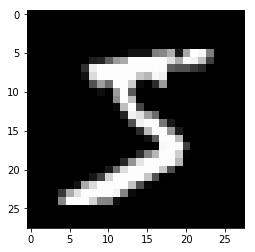

In [3]:
plt.imshow(train_data[0], 'gray')

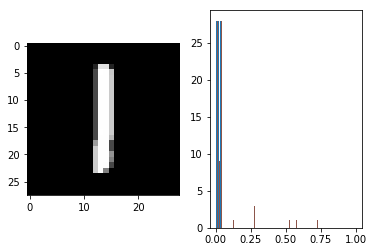

In [4]:
# show data
idx = np.random.randint(0, train_data.shape[0])
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[idx]
# ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax1.imshow(np.array(sample_data*255, dtype=np.uint8), 'gray')
ax2.hist(sample_data, bins=20, range=[0, 1]);

## Delete summary folder and make it

In [5]:
SUMMARY_DIR = './gan_summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'
IMAGE_DIR = SUMMARY_DIR + '/image'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)
    os.makedirs(IMAGE_DIR)

## Define tensorflow graph

In [6]:
test = tf.placeholder(tf.float32, shape=[10, 128], name = 'test')
print(test.shape[1])
print(test.get_shape())

128
(10, 128)


In [7]:
def fully_connected(inputs, out_channel, name='fc'):
    """
    very simple fully connected layer function

    Args:
        inputs: a batch of input tensor [batch_size, n]
                where n is the number of input feature dimension
        out_channel: output channel dimension

    Returns:
        fc: inputs * weights + biases [batch_size, out_channel]
    """
    # Define weight matrix variable, bias vector variable
    with tf.variable_scope(name):
        # To share the variables you have to use
        # a function 'tf.get_variable' instead of 'tf.Variable'
        # fc : inputs * weights + biases
        # fc : [batch_size, n] *[n, out_channel ] = batch_size, [out_channeel]
        shp = inputs.shape.as_list()[1]
        weights = tf.get_variable('w', shape=[shp, out_channel],
                                  initializer = tf.initializers.truncated_normal(stddev=0.02))#-1, 1f=로 다 자른거
                                 # initializer = tf.initializers.glorot_normal
                                 # initializer = tf.initializers.he_normal # 이건 relu할 때 
        biases = tf.get_variable('b', shape=[out_channel],
                                  initializer = tf.initializers.zeros)#-1, 1f=로 다 자른거
        
        #fc = tf.matmul(inputs, weights) + biases
        fc = inputs @ weights + biases
        # @ -> metrics multification

        return fc

In [8]:
def discriminator(x, reuse=None): #이미지가져와서 진짜 가짜 판별
    """
    build the discriminator

    Args:
        x: a batch of input to the network [batch_size, 28, 28, 1]

    returns:
        net: output of the discriminator [batch_size, 1]
    """
    with tf.variable_scope('discriminator') as scope:
        if reuse: # 꼭 필요함!
            scope.reuse_variables() 

        # Vectorize the input x
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 1 output units and 'fc2' as its name
        # Apply non-linearity function 'sigmoid'
        # Return the final tensor
        net = tf.reshape(x, [-1, 28*28*1])
        net = fully_connected(net, 256, 'fc1')
        net = tf.nn.relu(net)
        net = fully_connected(net, 256, 'fc2')
        net = tf.nn.sigmoid(net)
        
        return net


def generator(z):
    """
    build the generator

    Args:
        z: a batch of input to the network [batch_size, z_dim(노이즈)]

    Returns:
        net: output of the generator [batch_size, 28, 28, 1]
    """
    with tf.variable_scope('generator') as scope:

        # Unlike the discriminator, input z is a set of vectors
        
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 784 output units and 'fc2' as its name
        # Apply non-linearity function 'sigmoid'
        # Reshape final output to be a proper image file [28, 28, 1]
        # Return the final tensor
        net = fully_connected(z, 256, 'fc1')
        net = tf.nn.relu(net)
        net = fully_connected(net, 784, 'fc2')
        net = tf.nn.sigmoid(net) #0~1값으로 바꾸기 위해서
        net = tf.reshape(net, [-1, 28, 28, 1])
        return net


def get_loss(D_real, D_fake, eps=1e-10):
    """
    get loss of GAN

    Args:
        D_real: Real Discriminator output [batch_size, 1]
        D_rake: Fake discriminator output [batch_size, 1]

    Returns:
        D_loss: Discriminator loss
        G_loss: Generator loss
    """
    D_loss = -tf.reduce_mean(tf.log(D_real+eps) + tf.log(1-D_fake+eps)) # batch때문에 평균 구한다.
    #G_loss = tf.reduce_mean( tf.log(1-D_fake) ) # 1빼도 되고 -1 붙여도댐
    G_loss = -tf.reduce_mean( tf.log( D_fake ))

    return D_loss, G_loss


def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)

    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label

In [9]:
# Set hyperparameters
batch_size = 100
z_dim = 128
max_step = 20000
lr = 0.001
beta1 = 0.9

train_data = np.expand_dims(train_data, 3)
test_data = np.expand_dims(test_data, 3)

In [10]:
############################# Build the model #############################
# Define image tensor x placeholder
x = tf.placeholder(tf.float32, [batch_size, 28, 28, 1], name='input_x')
# Define z vector as uniform distribution between [-1, 1]
z = tf.random_uniform((batch_size, z_dim), -1., 1., name='latent_z') # Random한 constant 생성

# Build discriminator where input data is real image x
D_real = discriminator(x, reuse=False) #x가 들어왔을 때 build했을 때 get_variable를 만들지 않았을니깐 False
# Build generator
G = generator(z)
# Build discriminator where input data is generated image G
D_fake = discriminator(G, reuse=True) #get_variable을 그대로 씀. Weight가 같아야함. 아까 만들었떤 w를 reuse해서 계산할거야라고 선언

# Get D_loss and G_loss
D_loss, G_loss = get_loss(D_real, D_fake)

# Make optimization op
opt = tf.train.AdamOptimizer(lr, beta1=beta1)

# To update the generator and the discriminator
# get their network parameters
G_params = [param for param in tf.trainable_variables()
            if 'generator' in param.name]
D_params = [param for param in tf.trainable_variables()
            if 'discriminator' in param.name]

# Make train op for each network
D_train = opt.minimize(D_loss, var_list=D_params)
G_train = opt.minimize(G_loss, var_list=G_params)

# Make initialization op
init = tf.global_variables_initializer()

# Add summary and make op to add summary data to event log
tf.summary.scalar('Generator_loss', G_loss)
tf.summary.scalar('Discriminator_loss', D_loss)
merged = tf.summary.merge_all()

## Train GAN

Training data


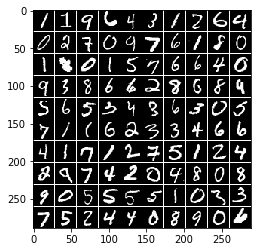

0 steps |  G_loss: 0.7224, D_loss: 1.3885


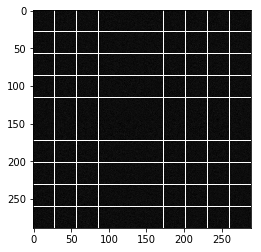

200 steps |  G_loss: 6.1161, D_loss: 0.0155


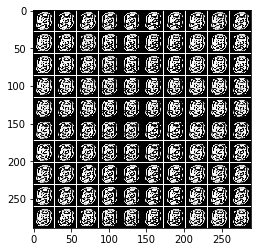

400 steps |  G_loss: 6.2660, D_loss: 0.0045


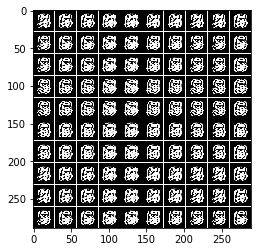

600 steps |  G_loss: 6.6457, D_loss: 0.0060


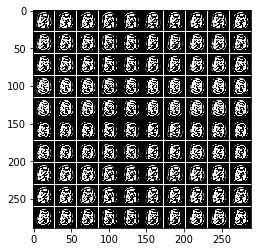

800 steps |  G_loss: 7.2347, D_loss: 0.0213


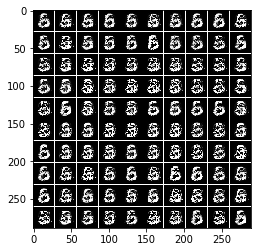

1000 steps |  G_loss: 6.0334, D_loss: 0.0326


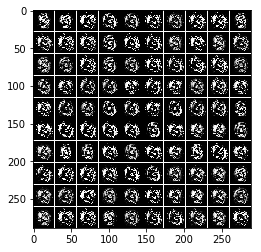

1200 steps |  G_loss: 7.8854, D_loss: 0.0278


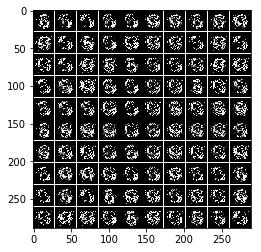

1400 steps |  G_loss: 7.5920, D_loss: 0.0371


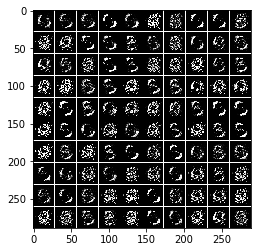

1600 steps |  G_loss: 6.7887, D_loss: 0.0215


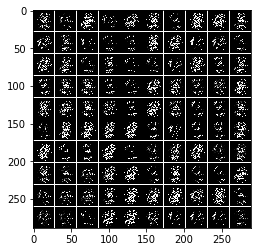

1800 steps |  G_loss: 7.4420, D_loss: 0.0288


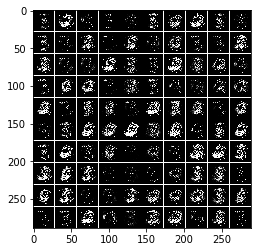

2000 steps |  G_loss: 7.2297, D_loss: 0.0132


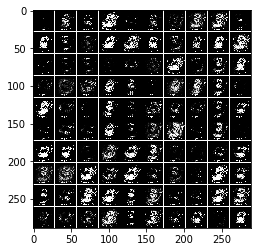

2200 steps |  G_loss: 6.2251, D_loss: 0.0444


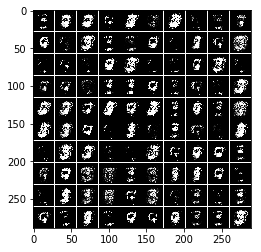

2400 steps |  G_loss: 6.3009, D_loss: 0.0103


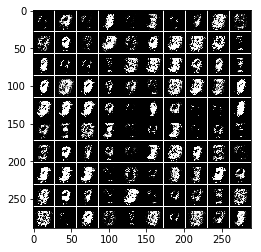

2600 steps |  G_loss: 4.7716, D_loss: 0.0587


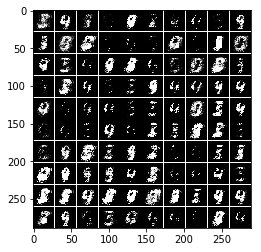

2800 steps |  G_loss: 5.6528, D_loss: 0.0590


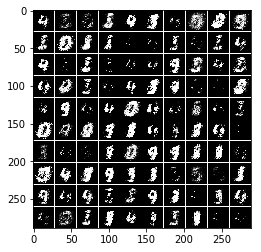

3000 steps |  G_loss: 5.3966, D_loss: 0.1127


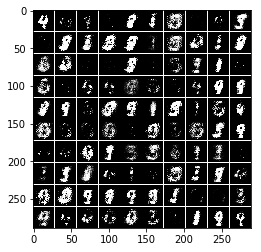

KeyboardInterrupt: 

In [11]:
with tf.Session() as sess:
    # Define writer
    train_writer = tf.summary.FileWriter(TRAIN_DIR, sess.graph)
    test_writer = tf.summary.FileWriter(TEST_DIR)
    
    # Initialize variables
    sess.run(init)
    
    # Before train the model, shows train data and save it
    batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
    train_tiled = img_tile(batch_x, border_color=1.0)
    train_tiled = np.squeeze(train_tiled)
    print("Training data")
    plt.imshow(train_tiled, cmap=plt.cm.gray)
    plt.show()
    plt.imsave(IMAGE_DIR + '/train.png', train_tiled, cmap=plt.cm.gray)
    
    samples = []
    for step in range(max_step):
        batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
        
        _, d_loss = sess.run([D_train, D_loss], feed_dict={x: batch_x})
        _, g_loss = sess.run([G_train, G_loss])
        summary = sess.run(merged, feed_dict={x: batch_x})
        train_writer.add_summary(summary, step)
        
        # Save generarted data to make gif files
        if step % 50 == 0:
            g = sess.run(G)
            g_tiled = img_tile(g, border_color=1.0)
            g_tiled = np.squeeze(g_tiled)
            samples.append(g_tiled)
        if step % 200 == 0:
            print("{} steps |  G_loss: {:.4f}, D_loss: {:.4f}".format(step, g_loss, d_loss))
            plt.imshow(g_tiled, cmap=plt.cm.gray)
            plt.show()
            plt.imsave(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)),
                       g_tiled, cmap=plt.cm.gray)
#             plt.close()



In [ ]:
import imageio
# Make gif files
imageio.mimsave(SUMMARY_DIR + '/generated.gif', samples)